In [3]:
# Импорт необходимых модулей 
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Настройки для визуализации
# Если используется темная тема - лучше текст сделать белым
TEXT_COLOR = 'black'

matplotlib.rcParams['figure.figsize'] = (10, 5)
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)

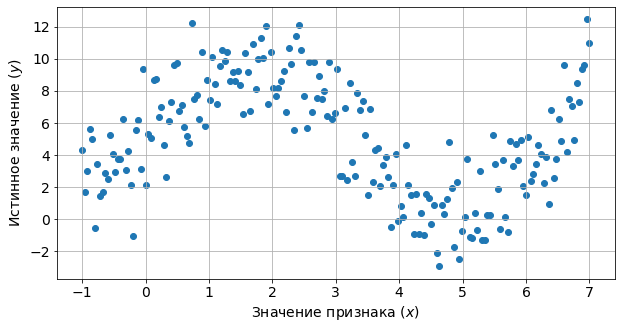

In [4]:
X_data = np.linspace(-1, 7, 200)[:, None]
y_data = np.sin(X_data[:,0])*5 + np.random.normal(size=X_data.shape[0])*2 + 5

# Посмотрим на данные
plt.scatter(X_data[:,0], y_data)
plt.grid(True)
plt.xlabel('Значение признака ($x$)')
plt.ylabel('Истинное значение ($y$)')
plt.show()

In [5]:
class MeanPredictor:
    def __init__(self):
        self.y_mean = 0

    def fit(self, X, y):
        self.y_mean = np.mean(y)

    def predict(self, X):
        return np.full(X.shape[0], self.y_mean)

In [7]:
# TEST

X = np.array([
    [0, 1, 2],
    [3, 1, 1],
    [0, 0, 1],
])
y = np.array([0, 1, 2])

mean_model = MeanPredictor()
mean_model.fit(X, y)

y_pred = mean_model.predict(X)

assert len(y_pred.shape) == 1
assert y_pred.shape[0] == 3
assert np.all(y_pred == np.array([1, 1, 1]))

In [8]:
X = X_data
y_true = y_data

weak_mean = MeanPredictor()
weak_mean.fit(X, y_true)

y_pred = weak_mean.predict(X)
print(y_pred[:5])

[5.00670035 5.00670035 5.00670035 5.00670035 5.00670035]


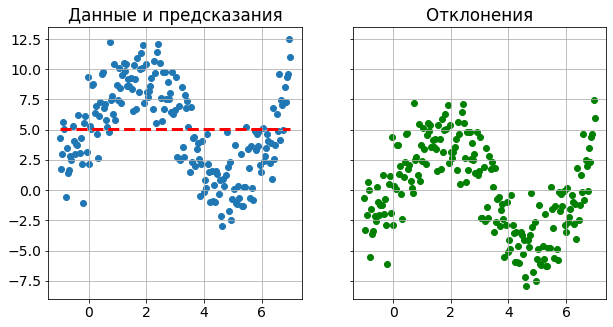

In [9]:
y_pred_0 = weak_mean.predict(X)
y_resid_0 = y_true-y_pred_0

X_vis = np.linspace(X_data.min(), X_data.max(), 100)[:, None]
y_pred_vis = weak_mean.predict(X_vis)

fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].plot(X_vis, y_pred_vis, 'r--', lw=3)
ax[0].scatter(X_data, y_data)
ax[0].set_title('Данные и предсказания')
ax[0].grid(True)

ax[1].scatter(X_data, y_resid_0, color='green')
ax[1].set_title('Отклонения')
ax[1].grid(True)

plt.show()

In [10]:
from sklearn.metrics import r2_score

r2_value_0 = r2_score(y_true, y_pred_0)
print(f'R2 score for step 0 = {r2_value_0}')

R2 score for step 0 = 0.0


In [11]:
from sklearn.metrics import mean_squared_error as mse_score

mse_value_0 = mse_score(y_true, y_pred_0)
print(f'MSE score for step 0 = {mse_value_0}')

MSE score for step 0 = 13.30510778360694


In [12]:
from sklearn.tree import DecisionTreeRegressor

weak_stump = DecisionTreeRegressor(
    max_depth=1,
    random_state=RANDOM_STATE
)

weak_stump.fit(X_data, y_resid_0)

y_pred_1 = weak_stump.predict(X_data)
y_resid_1 = y_data-(y_pred_0+y_pred_1)

[Text(279.0, 203.85000000000002, 'X[0] <= 3.482\nmse = 13.305\nsamples = 200\nvalue = 0.0'),
 Text(139.5, 67.94999999999999, 'mse = 8.353\nsamples = 112\nvalue = 1.835'),
 Text(418.5, 67.94999999999999, 'mse = 9.863\nsamples = 88\nvalue = -2.336')]

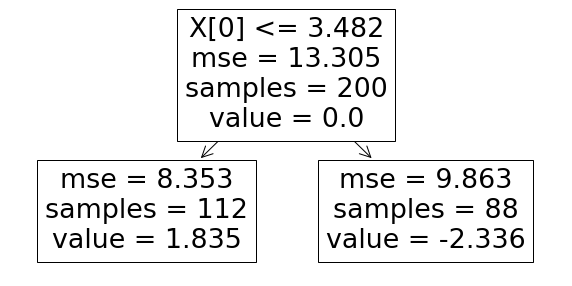

In [13]:
from sklearn import tree

tree.plot_tree(weak_stump)

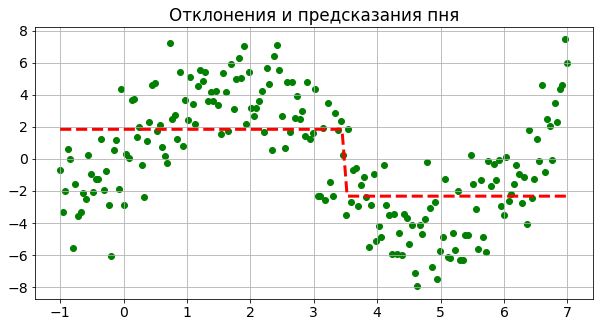

In [14]:
y_pred_1_vis = weak_stump.predict(X_vis)

plt.plot(X_vis, y_pred_1_vis, 'r--', lw=3)
plt.scatter(X_data, y_resid_0, color='green')
plt.grid(True)
plt.title('Отклонения и предсказания пня')
plt.show()

In [15]:
y_pred_0 = weak_mean.predict(X)
y_pred_1 = y_pred_0 + weak_stump.predict(X)

print(y_pred_1[:4])

[6.84213865 6.84213865 6.84213865 6.84213865]


In [16]:
r2_value_1 = r2_score(y_true, y_pred_1)
print(f'R2 score for step 1 = {r2_value_1}')

R2 score for step 1 = 0.3222526761213005


In [17]:
gb_model = [weak_mean, weak_stump]

In [18]:
def predict_gb(gb_model, X):
    '''
    gb_model - список слабых моделей в ансамбле в порядке обучения
    '''

    y_pred = None
    for model in gb_model:
        if y_pred is None:
            y_pred = model.predict(X)
        else:
            y_pred += model.predict(X)
    
    return y_pred

In [19]:
# TEST
# Проведем тест прямо на наших данных!

y_pred = predict_gb(gb_model, X_data)

assert y_pred.shape[0] == X.shape[0]
assert len(y_pred.shape) == 1
# Так как не добавляли моделе в ансамбль, сейчас предсказания должны сойтись!
assert np.all(y_pred == y_pred_1)

In [20]:
def plot_model(gb_model, X, y):
    X_vis = np.linspace(X.min(), X.max(), 100)[:, None]
    y_resid = y-predict_gb(gb_model, X)
    y_pred_vis = predict_gb(gb_model, X_vis)

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=[10, 5])
    ax[0].plot(X_vis, y_pred_vis, 'r--', lw=3)
    ax[0].scatter(X, y)
    ax[0].set_title('Данные и модель бустинга')
    ax[0].grid(True)

    ax[1].scatter(X, y_resid, color='green')
    ax[1].set_title('Отклонения')
    ax[1].grid(True)

    plt.show()

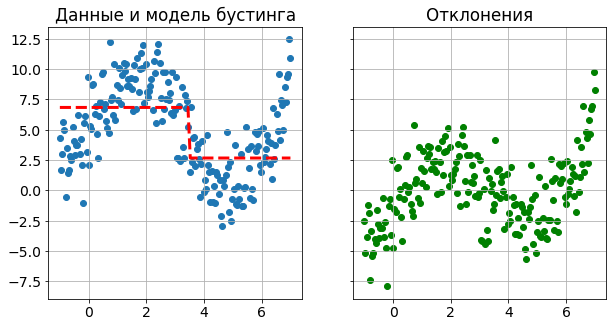

Current MSE score: 9.017501194257258


In [21]:
X = X_data
y_true = y_data

plot_model(gb_model, X, y_true)

y_pred = predict_gb(gb_model, X)
mse_value = mse_score(y_true, y_pred)
print(f'Current MSE score: {mse_value}') 

In [22]:
def fit_new_weak_model(gb_model, X, y):
    y_pred = predict_gb(gb_model, X)
    y_resid = y-y_pred

    weak_stump = DecisionTreeRegressor(
        max_depth=1,
        random_state=RANDOM_STATE
    )

    weak_stump.fit(X, y_resid)

    return weak_stump

In [23]:
# TEST
# Тут мы опять сразу проверим на наших данных

X = X_data
y_true = y_data

new_model = fit_new_weak_model(gb_model, X, y_true)

assert isinstance(new_model, DecisionTreeRegressor)
assert np.isclose(np.mean(new_model.predict(X)), 0)

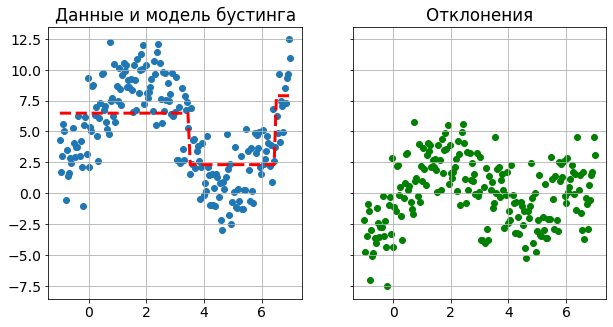

R2: 0.46456635036728644 | MSE: 7.124002419333289


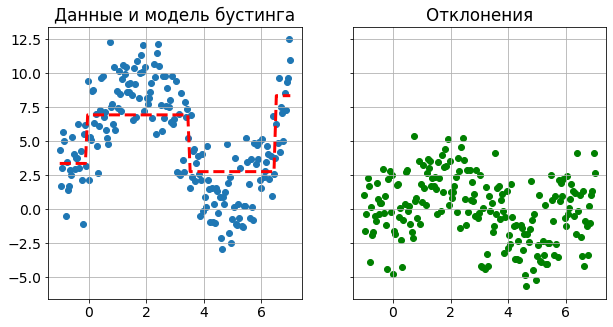

R2: 0.5656992944360695 | MSE: 5.778417698024639


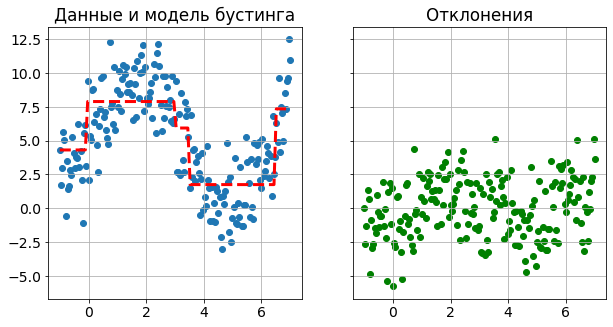

R2: 0.637235565583621 | MSE: 4.826619899969134


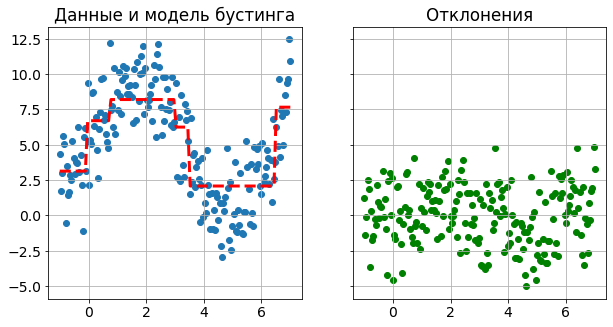

R2: 0.6657368659277549 | MSE: 4.447407026917479


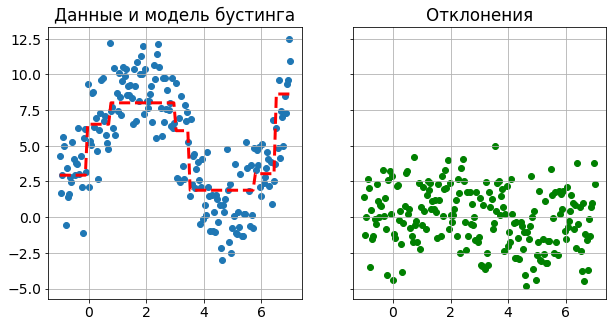

R2: 0.6793246061515048 | MSE: 4.266620678704835


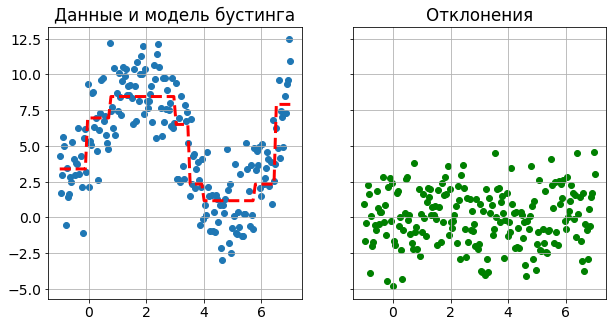

R2: 0.703510141269348 | MSE: 3.9448295271577205


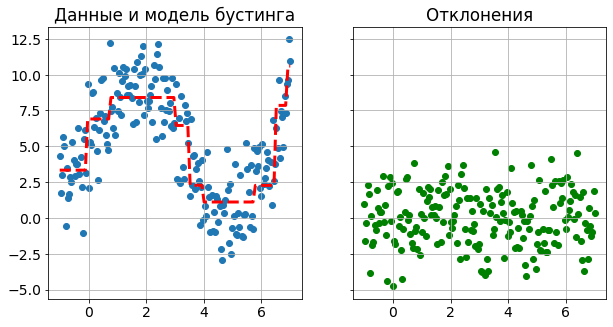

R2: 0.714623765570831 | MSE: 3.796961557959976


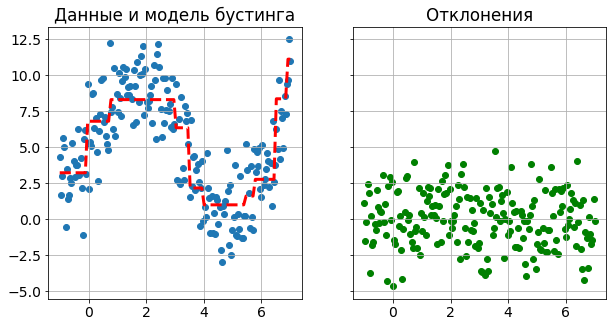

R2: 0.7189767981284318 | MSE: 3.739043990595546


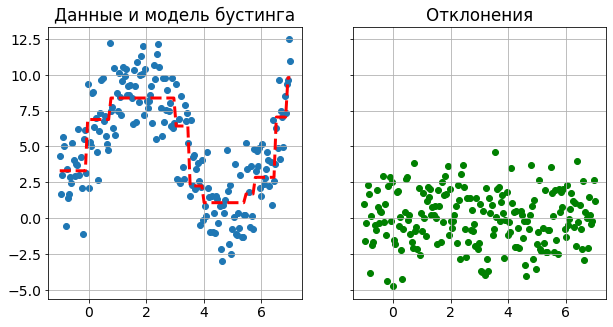

R2: 0.7277262433563045 | MSE: 3.6226316787919353


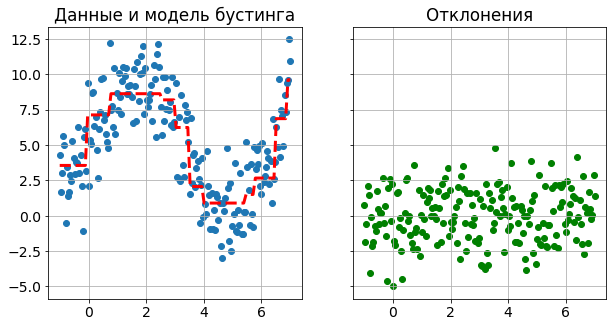

R2: 0.7312435382786486 | MSE: 3.575833690743413


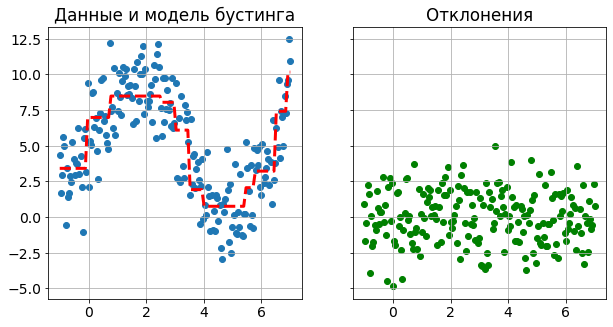

R2: 0.7369773194636327 | MSE: 3.499545114069582


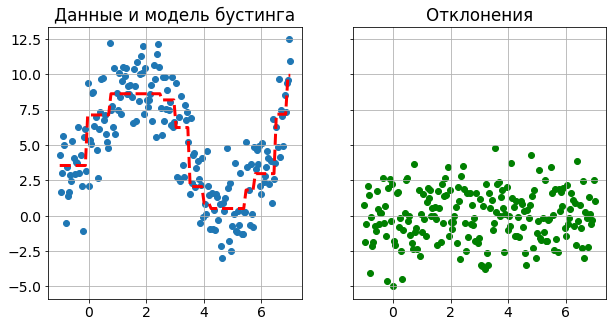

R2: 0.7394533128604452 | MSE: 3.4666017550534924


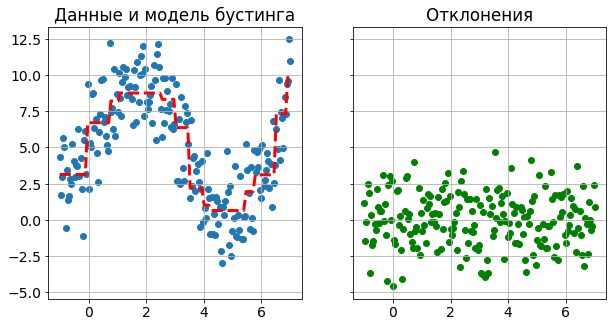

R2: 0.7437706504408752 | MSE: 3.409159113207656


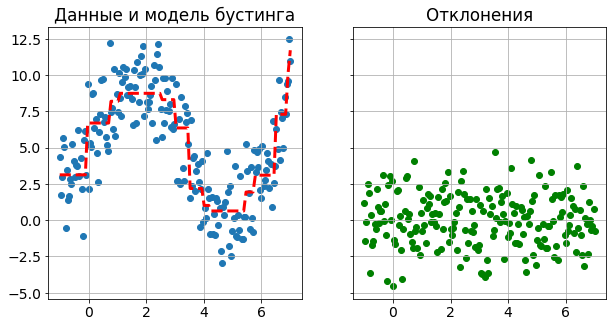

R2: 0.7458430473590103 | MSE: 3.3815856488414524


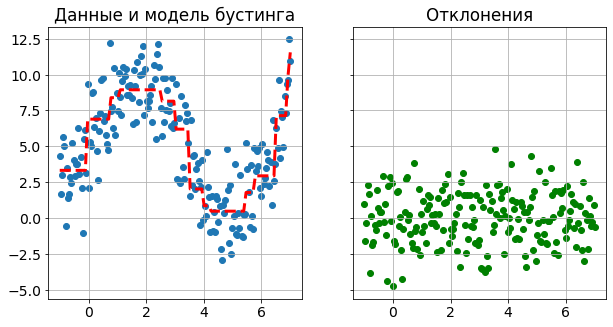

R2: 0.748194097758299 | MSE: 3.350304669874224


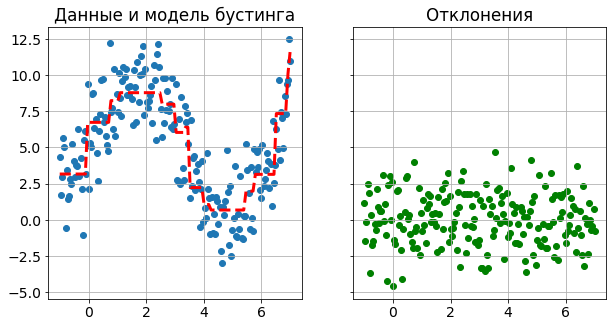

R2: 0.7506203212326514 | MSE: 3.318023505040849


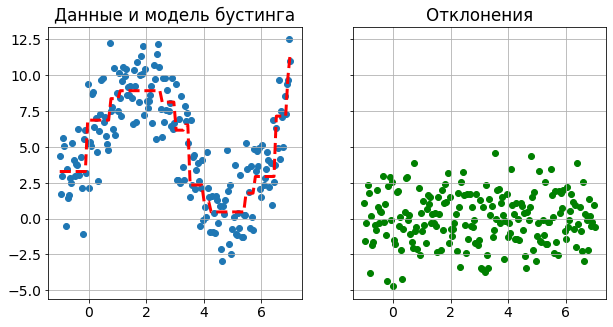

R2: 0.7524168369112981 | MSE: 3.294120670301514


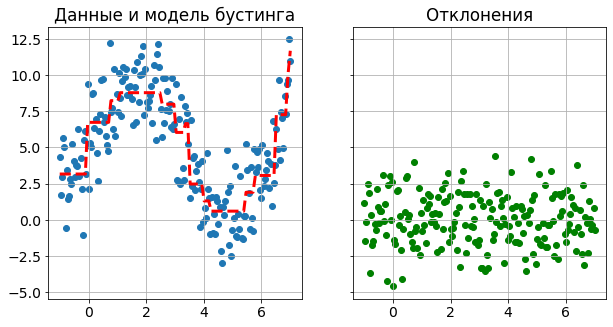

R2: 0.7535524270894394 | MSE: 3.27901152058334


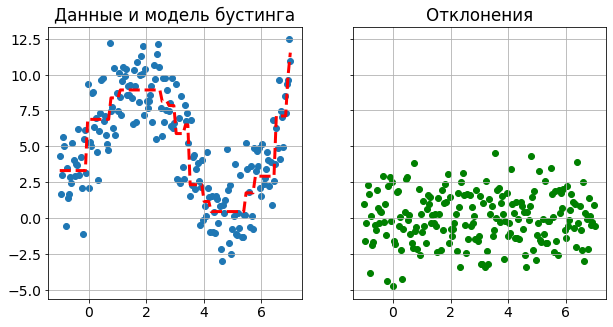

R2: 0.755164082338722 | MSE: 3.257568273781618


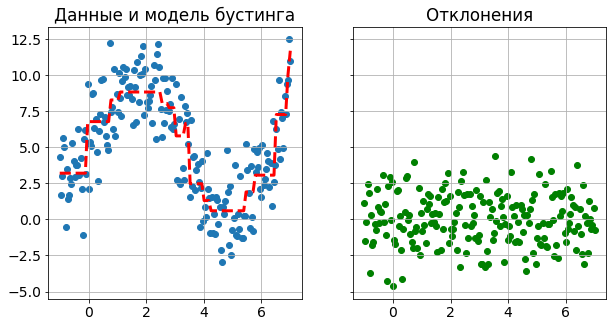

R2: 0.7563815521671458 | MSE: 3.2413697064911497


In [24]:
X = X_data
y_true = y_data

for i in range(20):
    new_model = fit_new_weak_model(gb_model, X, y_true)
    gb_model.append(new_model)

    y_pred = predict_gb(gb_model, X)

    r2_value = r2_score(y_true, y_pred)
    mse_value = mse_score(y_true, y_pred)

    plot_model(gb_model, X, y_true)
    print(f'R2: {r2_value} | MSE: {mse_value}')

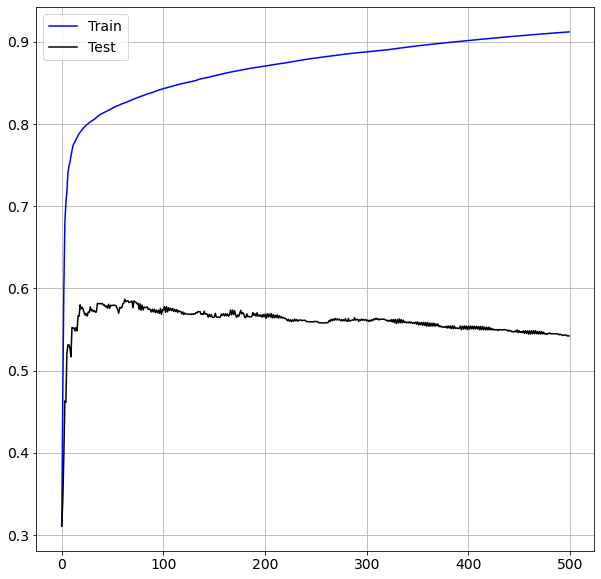

In [25]:
# Task 1 
# TODO - вот здесь пишем код разделения, обучения, оценки и отображения графика R2
# NOTE - создайте новую модель, не используйте старый gb_model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.3, random_state=RANDOM_STATE)

start_model = MeanPredictor()
start_model.fit(X_train, y_train)

gb_model = [start_model]
r2_values_train = []
r2_values_test = []

# А вот здесь пишем код разделения и обучения =)
for i in range(500):
    new_model = fit_new_weak_model(gb_model, X_train, y_train)
    gb_model.append(new_model)

    y_pred = predict_gb(gb_model, X_train)
    r2_values_train.append(r2_score(y_train, y_pred))

    y_pred = predict_gb(gb_model, X_test)
    r2_values_test.append(r2_score(y_test, y_pred))

plt.figure(figsize=[10, 10])
plt.plot(r2_values_train, 'b', label='Train')
plt.plot(r2_values_test, 'k', label='Test')
plt.grid(True)
plt.legend()
plt.show()

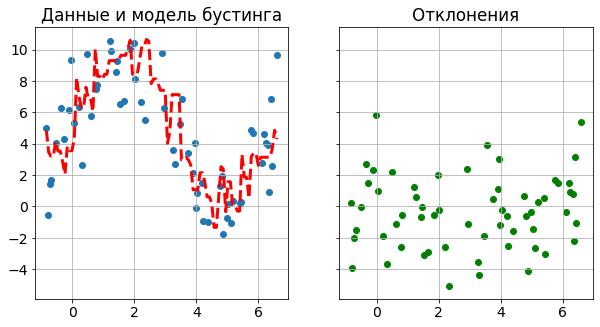

In [26]:
plot_model(gb_model, X_test, y_test)

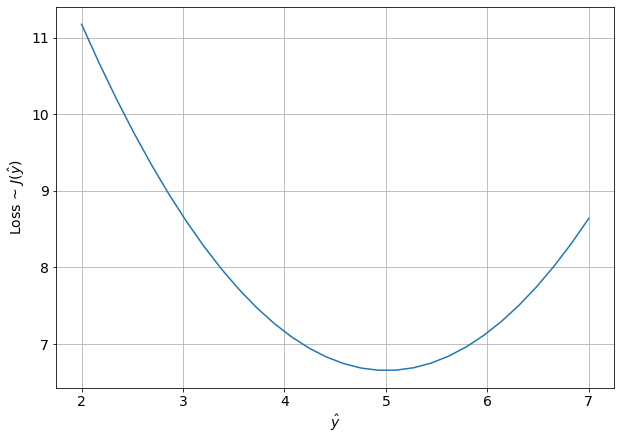

In [27]:
y_pred_vis = np.linspace(2, 7, 30)
loss_values = []

for y_pred_val in y_pred_vis:
    loss_value = mse_score(y_true, np.full_like(y_true, y_pred_val))/2
    loss_values.append(loss_value)

plt.figure(figsize=[10, 7])
plt.plot(y_pred_vis, loss_values)
plt.grid(True)
plt.ylabel('Loss ~ $J(\hat{y})$')
plt.xlabel('$\hat{y}$')
plt.show()

In [28]:
def plot_model_mae(gb_model, X, y):
    X_vis = np.linspace(X.min(), X.max(), 100)[:, None]
    y_resid = np.sign(y-predict_gb(gb_model, X))
    y_pred_vis = predict_gb(gb_model, X_vis)

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=[10, 5])
    ax[0].plot(X_vis, y_pred_vis, 'r--', lw=3)
    ax[0].scatter(X, y)
    ax[0].set_title('Данные и модель бустинга')
    ax[0].grid(True)

    ax[1].scatter(X, y_resid, color='green')
    ax[1].set_title('Отклонения')
    ax[1].grid(True)

    plt.show()

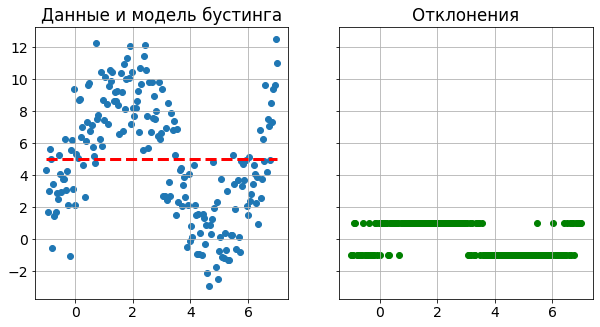

In [29]:
X = X_data
y_true = y_data

start_model = MeanPredictor()
start_model.fit(None, y_true)
gb_model = [start_model]

plot_model_mae(gb_model, X, y_true)

In [30]:
def fit_new_weak_model_mae(gb_model, X, y):
    y_pred = predict_gb(gb_model, X)
    y_resid = np.sign(y-y_pred)

    weak_stump = DecisionTreeRegressor(
        max_depth=1,
        random_state=RANDOM_STATE
    )

    weak_stump.fit(X, y_resid)

    return weak_stump

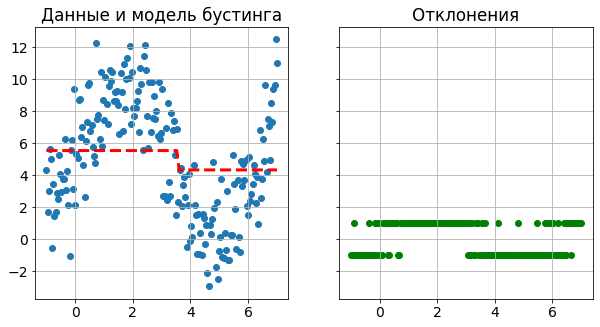

In [31]:
X = X_data
y_true = y_data

start_model = MeanPredictor()
start_model.fit(None, y_true)
gb_model_mae = [start_model]

new_model = fit_new_weak_model_mae(gb_model_mae, X, y_true)
gb_model_mae.append(new_model)

plot_model_mae(gb_model_mae, X, y_true)

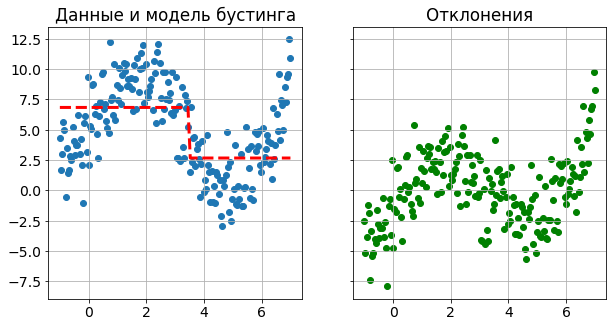

In [32]:
# А теперь для примера отобразим обучение с MSE
start_model = MeanPredictor()
start_model.fit(None, y_true)
gb_model_mse = [start_model]

new_model = fit_new_weak_model(gb_model_mse, X, y_true)
gb_model_mse.append(new_model)

plot_model(gb_model_mse, X, y_true)

In [33]:
from sklearn.datasets import load_wine

wine_data = load_wine()
feat_names = wine_data['feature_names']

df = pd.DataFrame(wine_data['data'], columns=feat_names)
df['CLASS'] = wine_data['target']

df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,CLASS
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


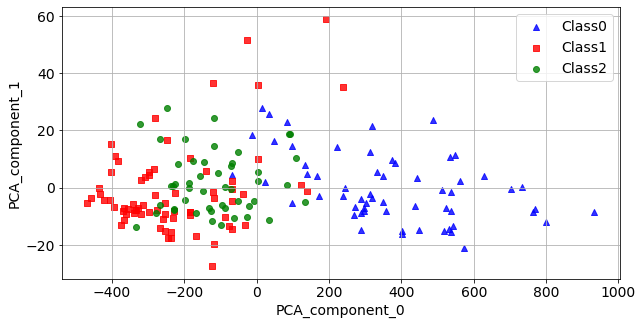

In [34]:
from sklearn.decomposition import PCA

X_df = df[feat_names]
y = df['CLASS']
target_names = [
    'Class0',
    'Class1',
    'Class2',
]

# Задается количество признаков, которое хотим получить
# Для визуализации понижаем количество признаков до 2х
pca = PCA(n_components=2)
pca.fit(X_df)
X_pca = pca.transform(X_df)

plt.figure()
for l, c, m in zip(range(0, 3), ('blue', 'red', 'green'), ('^', 's', 'o')):
    plt.scatter(
        X_pca[y == l, 0],
        X_pca[y == l, 1],
        color=c,
        label=target_names[l],
        alpha=0.8,
        marker=m
    )

plt.legend(target_names)
plt.xlabel('PCA_component_0')
plt.ylabel('PCA_component_1')
plt.grid()